In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("TASK2_dataset.csv")
df.head()

,song_id,keyword_1,keyword_2,keyword_3,genre
0,74,guitar,happy,distorted,rock
1,103,brass,energetic,melodic,classical
2,201,banjo,happy,acoustic,country
3,194,synth,energetic,heavy,hip-hop
4,184,synth,energetic,slow,hip-hop


In [4]:
n = len(df)

# creating a list of all unique words in each category
key1 = df.iloc[:, 1].unique().tolist()
key2 = df.iloc[:, 2].unique().tolist()
key3 = df.iloc[:, 3].unique().tolist()
genre = df.iloc[:, 4].unique().tolist()

# word count of unique words in each category
word_count_1 = len(key1)
word_count_2 = len(key2)
word_count_3 = len(key3)

word_count = word_count_1 + word_count_2 + word_count_3

print(key1)

['guitar', 'brass', 'banjo', 'synth', 'violin', 'piano']


In [5]:
# implementing TF IDF 
def TF(line, word):
    return line.count(word)/len(line)

def TF_IDF(arr, word, r, c):
    TF_ = np.count_nonzero(arr[r, :] == word) / len(arr[r, :])
    N = arr[:, c].shape[0]
    N_ = np.count_nonzero(arr[:, c] == word)
    IDF = np.log((N) / (N_))
    
    return TF_ * IDF

# function to take average of an array of points
def avg_points(y):
    if len(y) == 0:
        return np.zeros_like([0, 0])
    y_ = np.array(y)
    return (np.mean(y_, axis=0))

In [6]:
# creating numpy array to store vectors from TF IDF
row_1 = np.empty(n, dtype = list)
row_2 = np.empty(n, dtype = list)
row_3 = np.empty(n, dtype = list)

# creating the vectors
for i in range(n):

    row_1[i] = {k: TF_IDF(df.to_numpy(), k, i, 1) for k in key1}

    row_2[i] = {k: TF_IDF(df.to_numpy(), k, i, 2) for k in key2}    

    row_3[i] = {k: TF_IDF(df.to_numpy(), k, i, 3) for k in key3}
    
# reshaping the array as per convenience    
row_1 = [list(d.values()) for d in row_1]
row_2 = [list(d.values()) for d in row_2]
row_3 = [list(d.values()) for d in row_3]

row_1 = np.array(row_1)
row_2 = np.array(row_2)
row_3 = np.array(row_3)

print(row_1)

[[0.16320906 0.         0.         0.         0.         0.        ]
 [0.         0.51850746 0.         0.         0.         0.        ]
 [0.         0.         0.63973462 0.         0.         0.        ]
 [0.         0.         0.         0.24584649 0.         0.        ]
 [0.         0.         0.         0.24584649 0.         0.        ]
 [0.         0.51850746 0.         0.         0.         0.        ]
 [0.16320906 0.         0.         0.         0.         0.        ]
 [0.16320906 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5375695  0.        ]
 [0.16320906 0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.50110519]
 [0.         0.         0.         0.         0.5375695  0.        ]
 [0.16320906 0.         0.         0.         0.         0.        ]
 [0.         0.51850746 0.         0.         0.         0.        ]
 [0.16320906 0.         0.        

In [7]:
# Implementing PCA 
def PCA_(arr, r, c, dim):
    # edge case
    if dim > c:
        return -1
    # centering the vectors
    avg = np.mean(arr, axis=0)
    arr = arr - avg
    # creating a covarience matrix 
    cov_arr = np.cov(arr.T)
    # calculating and sorting the eigenvalues and eigenvectors of the matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_arr)
    sorted_indices = np.argsort(eigenvalues)[::-1]

    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    # converting the vectors to a dim dimentional vectors, conserving maximum possible information
    return np.dot(arr, eigenvectors[:, 0:dim])

# function to normalise array
def normal(arr):
    return (arr - np.min(arr, axis=0)) / (np.max(arr, axis=0) - np.min(arr, axis=0))

In [8]:
# applying PCA on the data

ve_1 = PCA_(row_1, n, word_count_1, 2)
ve_2 = PCA_(row_2, n, word_count_2, 2)
ve_3 = PCA_(row_3, n, word_count_3, 2)

y = ve_1 + ve_2 + ve_3
# combining each keywords data


In [9]:
def distance(arr1, arr2):
    return np.sqrt((arr1[0]-arr2[0])**2 + (arr1[1]-arr2[1])**2)



def k_mean(y, k, max_iterations=1000, tolerance=1e-3):
    
    n = len(y)
    
    # initialize points
    centroid = y[np.random.choice(n, size=k, replace=False)]
    
    for ii in range(max_iterations):
        clusters = [[] for _ in range(k)]
        for point in y:
            # adding a point to the cluster whose centroid is closest to the point
            dis = [distance(point, kk) for kk in centroid]
            i = np.argmin(dis)
            clusters[i].append(point)
        
        # Shifting the centroids to average of the clusters            
        n = np.array([avg_points(c) for c in clusters], dtype=np.float64)
        
        # stopping if no much variation in the location of the old and new centroids
        if np.all(np.abs(n - centroid) < tolerance):
            break
        
        centroid = n
    
    return clusters, centroid

In [10]:
def silhouette_score(clusters, centroids):
    score = 0
    total = sum(len(cluster) for cluster in clusters)
    for i in range(len(clusters)):
        # finding closest cluster
        clus1 = clusters[i]
        dis = [distance(centroids[i], centroids[j]) if i != j else np.inf for j in range(len(centroids))]
        # dis = [distance(centroids[i], kk) for kk in centroids]
        j = np.argmin(dis)
        clus2 = clusters[j]
        
        for point in clus1:
            a = 0
            b = 0
            for point2 in clus1:
                a += distance(point, point2)
            a = a/(len(clus1)-1)
            for point2 in clus2:
                b += distance(point, point2)
            b = b/len(clus2)
            score += (b-a)/(max(a, b))
            
    return score/total

In [11]:
# Function to plot the output of Clustering
def plot_clusters(clusters, centroids):
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    
    plt.figure(figsize=(10, 9))
    
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        plt.scatter(cluster[:, 0], cluster[:, 1], c=colors[i % len(colors)], label=f'Cluster {i+1}')
    
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, marker='*', label='Centroids')
    
    plt.title('K-Means Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

7
[np.float64(0.4323005785872538), np.float64(0.48243908257884666), np.float64(0.55408474244564), np.float64(0.5759541561287257), np.float64(0.6374922667141992), np.float64(0.5304449662481414), np.float64(0.6011071639445384), np.float64(0.6404534321890132)]


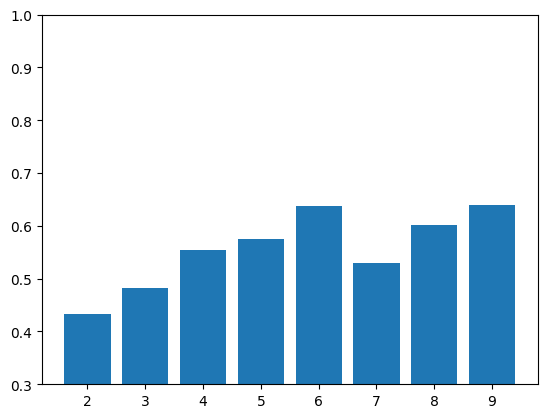

In [12]:
k_arr= []
for k in range(2, 10):
    cluster, centroid = k_mean(y, k)
    k_arr.append(silhouette_score(cluster, centroid))

category = range(2, 10)

plt.bar(category, k_arr)
plt.ylim(0.3, 1)

print(np.argmax(np.array(k_arr)))
print(k_arr)

In [13]:
k = 5
clusters, centroids = k_mean(y, k)

0.5850662857539843


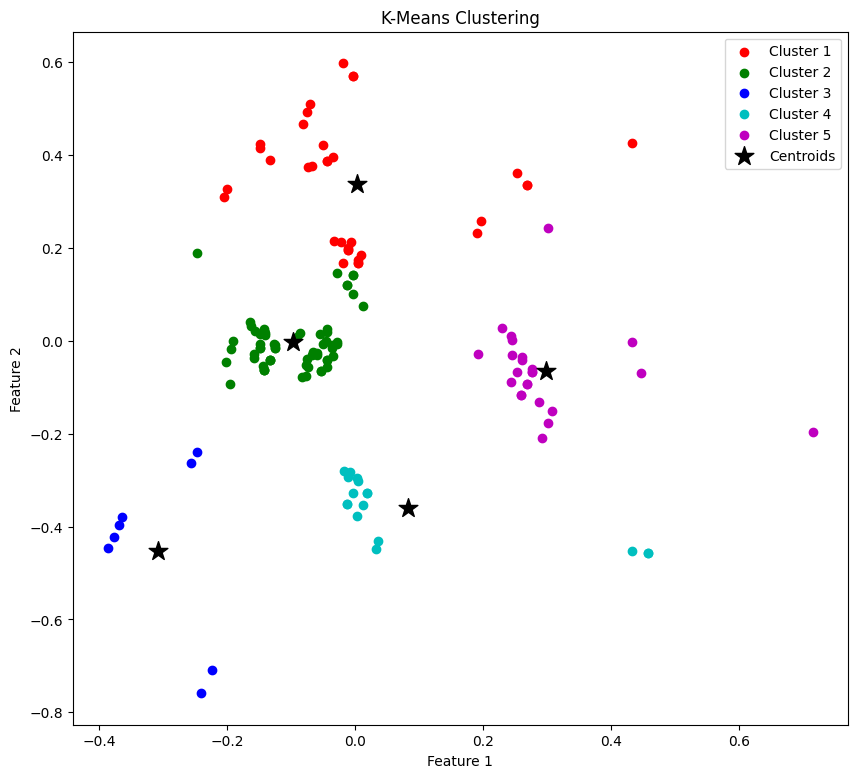

In [14]:
plot_clusters(clusters, centroids)
print(silhouette_score(clusters, centroids))

In [15]:
# Ground Truth Percentage
y_withgenre = np.concatenate((y, np.array(df.iloc[:, 4]).reshape(-1, 1)), axis=1)
def filter_(arr, cluster, word):
    cluster_set = {(j[0], j[1]) for j in cluster}  # Convert to a set 
    return [i for i in arr if i[2] == word and (i[0], i[1]) in cluster_set]

def cluster_percentage(arr, cluster, genre):
    percent = []
    for word in genre:
        percent_ = len(filter_(arr, cluster, word))/len(cluster)
        percent.append({word: round(100*percent_, 3)})
    
    return percent

for i in range(k):
    percent = cluster_percentage(y_withgenre, clusters[i], genre)
    print((percent))

[{'rock': 23.529}, {'classical': 23.529}, {'country': 17.647}, {'hip-hop': 23.529}, {'pop': 11.765}]
[{'rock': 28.125}, {'classical': 6.25}, {'country': 23.438}, {'hip-hop': 21.875}, {'pop': 20.312}]
[{'rock': 0.0}, {'classical': 100.0}, {'country': 0.0}, {'hip-hop': 0.0}, {'pop': 0.0}]
[{'rock': 0.0}, {'classical': 17.647}, {'country': 23.529}, {'hip-hop': 23.529}, {'pop': 35.294}]
[{'rock': 16.667}, {'classical': 16.667}, {'country': 16.667}, {'hip-hop': 16.667}, {'pop': 33.333}]


1
[{'rock': 5.0}, {'classical': 25.0}, {'country': 25.0}, {'hip-hop': 25.0}, {'pop': 20.0}]
2
[{'rock': 16.0}, {'classical': 36.0}, {'country': 16.0}, {'hip-hop': 16.0}, {'pop': 16.0}]
3
[{'rock': 26.667}, {'classical': 26.667}, {'country': 20.0}, {'hip-hop': 26.667}, {'pop': 0.0}]
4
[{'rock': 24.242}, {'classical': 6.061}, {'country': 18.182}, {'hip-hop': 18.182}, {'pop': 28.788}]
5
[{'rock': 20.833}, {'classical': 20.833}, {'country': 20.833}, {'hip-hop': 20.833}, {'pop': 16.667}]


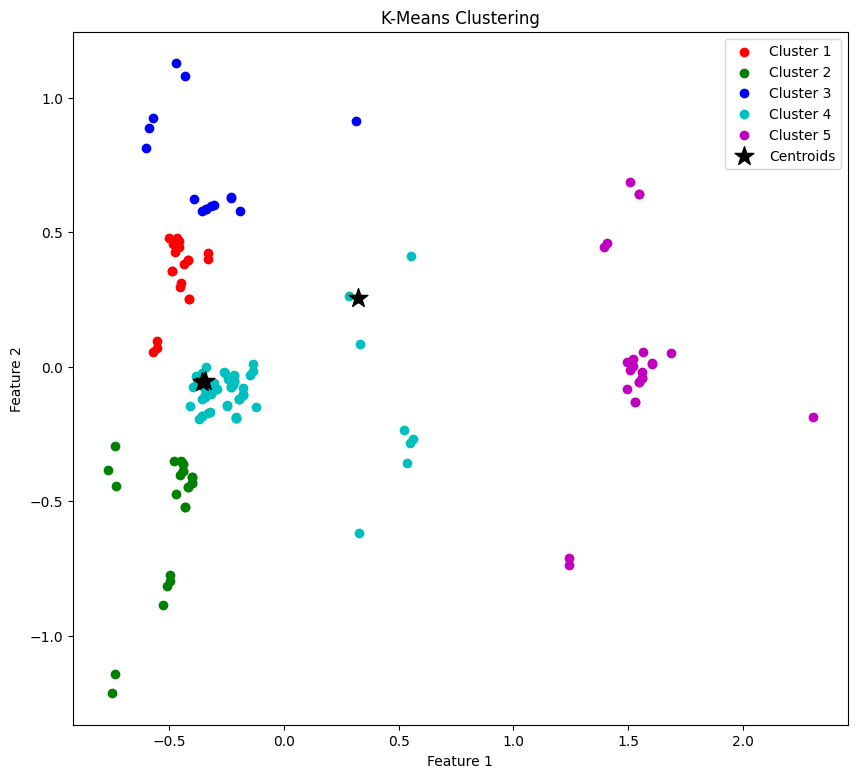

In [16]:
# Predicting genre of the 3 given songs

row_1_ = np.empty(n+3, dtype = list)
row_2_ = np.empty(n+3, dtype = list)
row_3_ = np.empty(n+3, dtype = list)

test_ = np.array([['piano', 'calm', 'slow'], 
        ['guitar', 'emotional', 'distorted'], 
        ['synth', 'mellow', 'distorted']
])

test_ = np.concatenate((test_, df.iloc[:, 1:4].to_numpy()), axis=0)

for i in range(n+3):

    row_1_[i] = {k: TF_IDF(test_, k, i, 0) for k in key1}
    row_2_[i] = {k: TF_IDF(test_, k, i, 1) for k in key2}    
    row_3_[i] = {k: TF_IDF(test_, k, i, 2) for k in key3}
    

row_1_ = [list(d.values()) for d in row_1_]
row_2_ = [list(d.values()) for d in row_2_]
row_3_ = [list(d.values()) for d in row_3_]

row_1 = np.array(row_1_)
row_2 = np.array(row_2_)
row_3 = np.array(row_3_)

ve_1_ = PCA_(row_1_, n+3, word_count_1, 2)
ve_2_ = PCA_(row_2_, n+3, word_count_2, 2)
ve_3_ = PCA_(row_3_, n+3, word_count_3, 2)

y_test = ve_1_ + ve_2_ + ve_3_

k = 5
clusters, centroids = k_mean(y_test, k)
plot_clusters(clusters, y_test[0:3, :])

y_test = y_test[3:, :]

y_test = np.concatenate((y_test, np.array(df.iloc[:, 4]).reshape(-1, 1)), axis=1)
for i in range(k):
    percent = cluster_percentage(y_test, clusters[i], genre)
    print(i+1)
    print((percent))